<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment-preparation" data-toc-modified-id="Environment-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Environment preparation</a></span><ul class="toc-item"><li><span><a href="#Libraries-and-functions" data-toc-modified-id="Libraries-and-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Libraries and functions</a></span></li></ul></li><li><span><a href="#Property-values-and-propensity-to-be-sold" data-toc-modified-id="Property-values-and-propensity-to-be-sold-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Property values and propensity to be sold</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression-method" data-toc-modified-id="Linear-Regression-method-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linear Regression method</a></span><ul class="toc-item"><li><span><a href="#Price-Distribution" data-toc-modified-id="Price-Distribution-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Price Distribution</a></span></li><li><span><a href="#Bivariate-Analysis---log(price)" data-toc-modified-id="Bivariate-Analysis---log(price)-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Bivariate Analysis - log(price)</a></span></li><li><span><a href="#Linear-Model-log(price)-of-sold-properties" data-toc-modified-id="Linear-Model-log(price)-of-sold-properties-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Linear Model log(price) of sold properties</a></span></li><li><span><a href="#Selling-price-prediction-of-unsold-properties" data-toc-modified-id="Selling-price-prediction-of-unsold-properties-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Selling price prediction of unsold properties</a></span></li></ul></li><li><span><a href="#Logistic-Regression-method" data-toc-modified-id="Logistic-Regression-method-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logistic Regression method</a></span><ul class="toc-item"><li><span><a href="#Bivariate-Analysis---Sold/Unsold" data-toc-modified-id="Bivariate-Analysis---Sold/Unsold-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Bivariate Analysis - Sold/Unsold</a></span></li><li><span><a href="#Logistic-Model---Propensity-to-be-sold" data-toc-modified-id="Logistic-Model---Propensity-to-be-sold-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Logistic Model - Propensity to be sold</a></span></li><li><span><a href="#Conditional-probabilities" data-toc-modified-id="Conditional-probabilities-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Conditional probabilities</a></span></li><li><span><a href="#Optimall-selling-price-strategy-unsold-properties" data-toc-modified-id="Optimall-selling-price-strategy-unsold-properties-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Optimall selling price strategy unsold properties</a></span></li></ul></li></ul></li></ul></div>

# Environment preparation


In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/griu/msc_python.git /content/msc_python
    !git -C /content/msc_python pull
    %cd /content/msc_python
    !pip install stargazer
    !pip install pyreadstat

fatal: destination path '/content/msc_python' already exists and is not an empty directory.
Already up to date.
/content/msc_python


__[Open in Colab](https://colab.research.google.com/github/griu/msc_python/blob/master/Property_Value_Propensity_Sell_Seminar.ipynb)__   *: <span style="color:rgba(255, 99, 71, 0.8)">Padawan! When you login to Colab, prepare the environment by running the following code.</span>*

## Libraries and functions

In [2]:
# Importing the packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import scipy.stats as stats
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML
import scipy
import math

# setting matplot theme
sns.set_theme(color_codes=True)

# Visualization
def visreg(fit, xvar, by, data, cond=dict()):
    
    # conditions
    allBy = np.sort(data[by].unique())
    
    # initializing dataframes
    df0 = pd.DataFrame(np.sort(data[xvar].copy().unique()),columns=[xvar])
    df0[by] = allBy[0] 
    df1 = df0.copy()
    
    # several copies by
    for x in allBy[1:]:
        df1[by] = x
        df0 = df0.append(df1, ignore_index=True)
        
    for k, v in cond.items():
        df0[k] = v
    
    # predict
    df0[fit.model.endog_names] = fit.predict(df0)
    
    ax = sns.lineplot(data = df0, x=xvar, y = fit.model.endog_names, hue = by)
    ax.set_title('Conditional effects plot')
    ax.set(ylabel='Prob(' + fit.model.endog_names + ')')

    return ax

# model comparision
def anovaLogit(fit1,fit2):
    Deviance = abs(-2*(fit2.model.loglike(fit2.params) - fit1.model.loglike(fit1.params)))
    DF = 2
    p_value = scipy.stats.chi2.sf(Deviance,DF)
    
    return {'Deviance':Deviance, 'DF':DF, 'p_value' : p_value}
    

# defining bivariate functions

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 10
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def bivar_bin(x,catVar,binVar,method = 'qcut',points = 7, saveTransf=False):
    # options for method: 'qcut', 'cut', None
    ind_transf = 0
    if saveTransf:
        x1 = x
    else:
        x1 = x.copy()

    # partitioning numerical column
    if (catVar in x1.select_dtypes('number').columns) and (method 
                                                          in ['qcut','cut']):
        if type(points) is list:
            if len(x1[catVar].unique()) > len(points):
                ind_transf = 1
        else:
            if len(x1[catVar].unique()) > points:
                ind_transf = 1
        if (ind_transf==1) and (method=="qcut"):
            x1[catVar + '_T'] = pd.qcut(x1[catVar], points,duplicates='drop')
            catVar = catVar + '_T'

        if (ind_transf==1) and (method=="cut"):
            x1[catVar + '_T'] = pd.cut(x1[catVar], points,right=False,duplicates='drop')
            catVar = catVar + '_T'
    
    # generating plots
    sns.set(rc={'figure.figsize':(11,4)})
    fig, ax = plt.subplots(1,2)
    
    sns.countplot(x=catVar,data=x1, ax=ax[0])
    ax[0].tick_params(labelrotation=90)
    ax[0].set(title=catVar+' distribution')
    
    sns.barplot(x=catVar,y=binVar, data=x1, ax=ax[1])
    ax[1].tick_params(labelrotation=90)
    ax[1].set(ylabel='Propensity '+binVar, title=binVar + ' % by '+catVar)
    
    # adding percentage to countplot
    without_hue(ax[0],x1[catVar])


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Property values and propensity to be sold 

The following data set corresponds to a sample of 1,000 house units in Spain on-sell during the 2008 crises:
`properties.csv`. The variable price is the offer price if variable sold = 0 and the transaction value if sold = 1 .

Your client is a real estate company and your mission is to help them to sell all the unsold properties by maximizing the profit from their sale.

1. *Linear regression method:*
   1. Inspect the distribution of the variable price and comment on whether to use the transformation log(price).
   1. Do a bivariate analysis between log(price) and other relevant explanatory factors in the sample.
   1. Use the log(price) as a dependent variable to fit what you feel is a relevant/useful regression model. Do this selecting only the sample of sold properties. Discuss the relevance of these regressions to understand the determinants of variable price. Summarize the findings that you find useful to inform your client.
   1. Explain to the client how can be used the previous model to calculate the discount or price increase, over the sample of unsold properties.
1. *Logistic regression method:*
   1. Do a bivariate analysis between sold variable and other relevant explanatory factors in the sample.
   1. Adjust a logistic regression model with overall sample using sold as a dependent variable. Assess which features of the properties can determine the sold or unsold status of the propertie.
   1. Use the previous model to plot the probability to be sold conditioned to the price by habitat size of a property with 150 square meters, non rural and without pool (add other conditions if you need). Interpret the plot for your client.
   1. Taking the conditional plot from the previous example, comment how this can be used to decide the optimal price to sell this property. Comment pros and cons of this method, compared to the selling price proposed in the linear regression section.


## Linear Regression method

Data loading:

In [3]:
df = pd.read_csv("properties.csv")

#casting region to categorical
df.region = df.region.astype("category")

df.shape

(1000, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   sold     1000 non-null   int64   
 1   price    1000 non-null   float64 
 2   rural    1000 non-null   object  
 3   pool     1000 non-null   object  
 4   surface  1000 non-null   float64 
 5   habSize  1000 non-null   object  
 6   region   1000 non-null   category
dtypes: category(1), float64(2), int64(1), object(3)
memory usage: 49.3+ KB


In [5]:
df.head()

,sold,price,rural,pool,surface,habSize,region
0,0,239443.2,No,No,189.20,"(10000,50000]",1
1,1,192000.0,No,No,149.22,"(50000,1000000]",5
2,1,200000.0,No,Yes,149.00,"(50000,1000000]",19
3,0,191763.0,No,No,112.63,"(10000,50000]",6
4,0,242500.0,No,No,103.25,"(10000,50000]",6


In [6]:
df.describe()

,sold,price,surface
count,1000.000000,1000.000000,1000.000000
mean,0.272000,218327.911527,151.465682
std,0.445213,94557.404857,59.685607
min,0.000000,51500.000000,50.820000
25%,0.000000,151109.297500,103.190000
50%,0.000000,203745.000000,141.670000
75%,1.000000,260000.000000,199.990000
max,1.000000,599820.260000,298.830000


In [7]:
df["pool"].value_counts()

No     894
Yes    106
Name: pool, dtype: int64

### Price Distribution

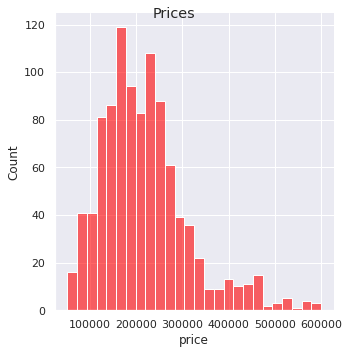

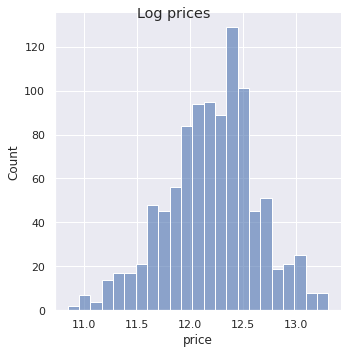

In [8]:
# Hint: look at sns.displot() function with log_scale=True parameter

g = sns.displot(df["price"], color = "red", alpha = 0.6).fig.suptitle("Prices");

g_log = sns.displot(np.log(df["price"]), alpha = 0.6).fig.suptitle("Log prices");

Comment: We will be using the log price transformation, as it is more resemblant to a normal distribution.

### Bivariate Analysis - log(price)

In [9]:
# Hint 1: use sns.pairplot(), sns.lmplot() and sns.boxplot() functions. 
# Hint 2: If its encessary, inspect any transformation/interaction that could help to linearize the relations
# Hint 3: Take care of possible high correlations between explanatory variables 

# transforming price to log_price 
df["log_price"] = np.log(df.price)

In [10]:
df.corr()["log_price"] # To see the correlations, from which we'll know what's best to plot together with price

sold        -0.133738
price        0.955100
surface      0.524674
log_price    1.000000
Name: log_price, dtype: float64

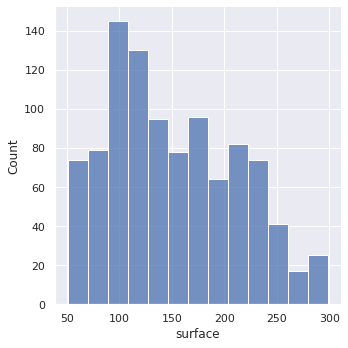

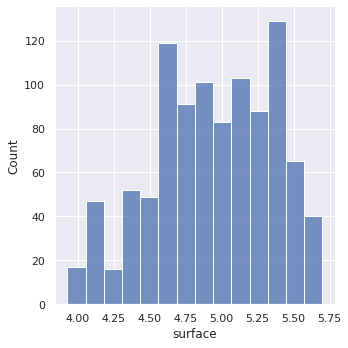

In [11]:
# Checking if we should use a log scale on the surface attribute as well
sns.displot(df.surface)
sns.displot(np.log(df.surface))

Looks like the better option is not changing the variable

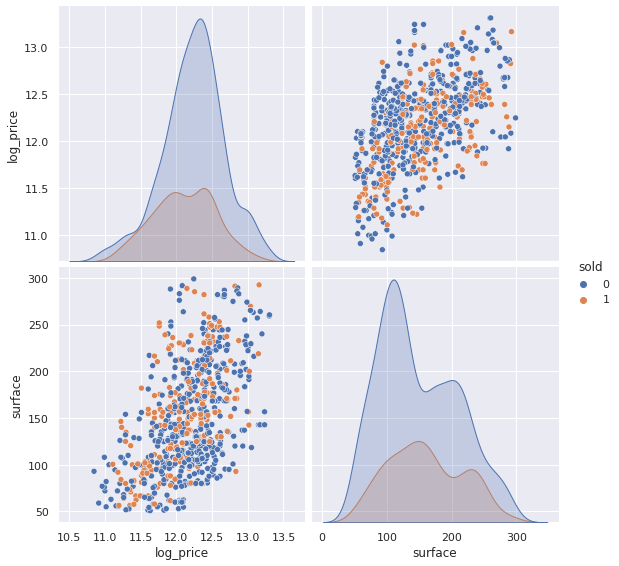

In [12]:
# Plotting the variables together

plot_attr = df[["log_price", "surface", "sold"]]

sns.pairplot(plot_attr, hue = "sold",  height = 4)

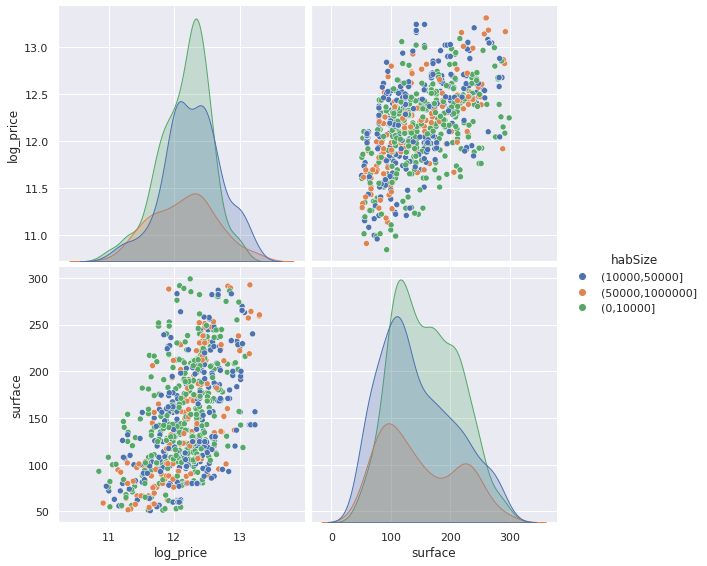

In [13]:
# Another data visualization, this time using the categorical variable habSize

plot_attr = df[["log_price", "surface", "habSize"]]

sns.pairplot(plot_attr, hue = "habSize",  height = 4)

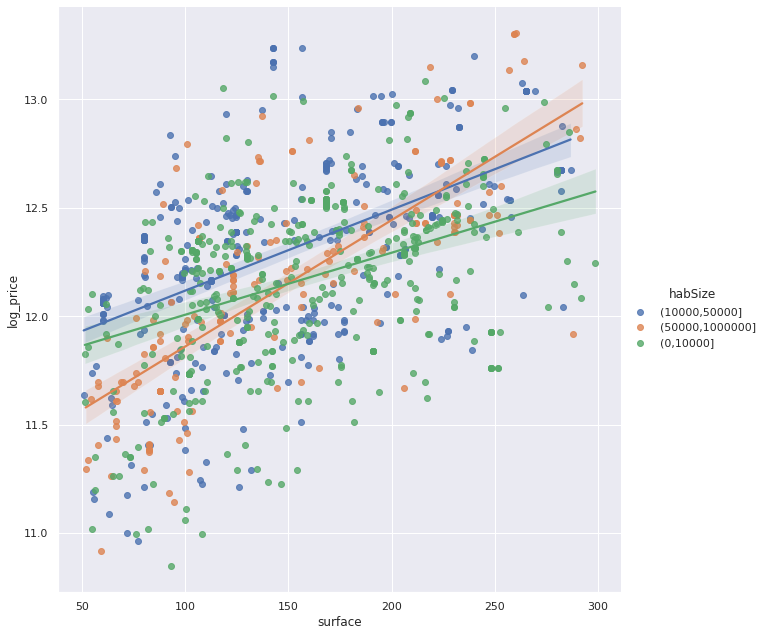

In [14]:
sns.lmplot(data= df, x="surface", y= "log_price", hue="habSize", ci = 95, height = 9, robust = True);

There exists a significant positive correlation (as per the CIs) between the surface area, size of rooms and the sell/offer price. So houses that come with bigger room sizes and/or more surface area will be able to be sold for more

### Linear Model log(price) of sold properties

In [15]:
# Hint 1: To create the DataFrame with sold properties use the condition [df.sold == 1]
# Hint 2: Comment the R2 and interpret the model with mod1.summary() and partial regression plots.
# Hint 3: Inspect the residuals versus prediction, vif and influential values

# To create a model that takes into account the categorical attributes as well as the numerical ones, we do a onehot encoding of the categorical variables with enough observations, which turns out to be only two attributes
df_lm = pd.get_dummies(df[["pool", "habSize"]])
df_lm["surface"] = df.surface.copy()
df_lm["sold"] = df.sold.copy()
df_lm["log_price"] = df["log_price"]

df_lm = df_lm[df_lm["sold"] == 1]

y = df_lm["log_price"]
X = df_lm.drop("log_price", axis = 1)

In [16]:
# First model: using relevant categorical variables 

#model = sm.OLS(y, X)

model = smf.ols(formula = "log_price ~ rural + surface + habSize + pool", data = df[df["sold"] == 1])
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     37.93
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           2.61e-29
Time:                        22:20:23   Log-Likelihood:                -82.060
No. Observations:                 272   AIC:                             176.1
Df Residuals:                     266   BIC:                             197.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     11.2765      0.069    162.497      0.000      11.140      11.413
rural[T.Yes]                  -0.5478      0.151     -3.633      0.000      -0.845      -0.251
habSize[T.(10000,50000]  ]     0.2312      0.047      4.936      0.000       0.139       0.323
habSize[T.(50000,1000000]]     0.2073      0.051      4.076      0.000       0.107       0.308
pool[T.Yes]                    0.1910      0.057      3.337      0.001       0.078       0.304
surface                        0.0043      0.000     11.730      0.000       0.004       0.005
==============================================================================
Omnibus:                        1.345   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.364
Skew:                           0.168   Prob(JB):                        0.506
Kurtosis:                       2.917   Cond. No.                     1.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of residuals')

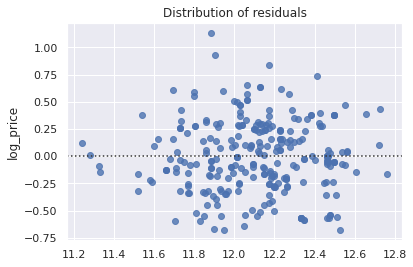

In [17]:
fitted = results.fittedvalues
sns.residplot(fitted, df[df["sold"] == 1]["log_price"]).set_title("Distribution of residuals")

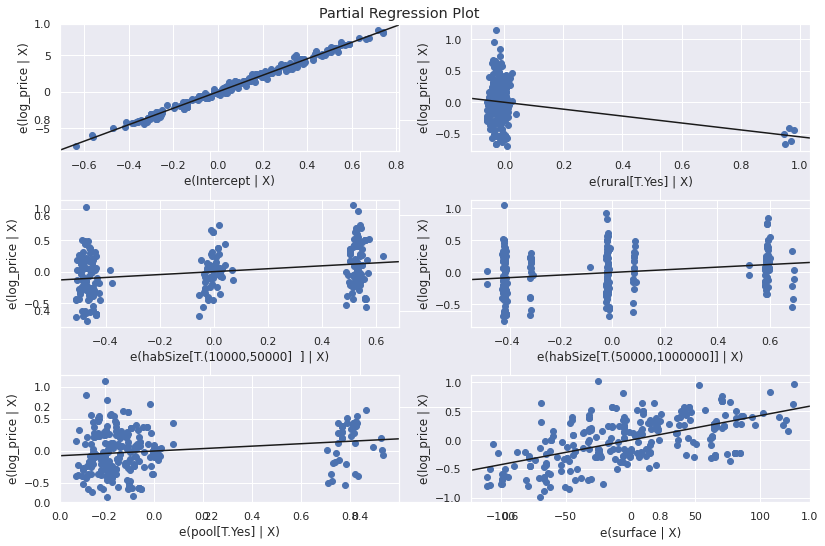

In [18]:
fig, ax =  plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results, fig=fig)

Comment: The most determinant features that make houses more valuable are (1) the location (rural areas are between 84% and 25% cheaper than non-rural), (2) the size of rooms –houses with rooms between 10.000sq.ft. and 50.000sq.ft are about a 23% more expensive than houses below 50.000sq.ft and quite surprisingly also more expensive than houses with rooms over 50.000sq.ft, the idea being that houses with bigger rooms will have less rooms given a fixed surface-. (3) having a pool (between a 7.8% and a 30.8% increase), and (4) more surface, where each extra square feet means a 0.4% increase on price.

### Selling price prediction of unsold properties

> Hint 1: mod1.predict(df1) predicts mod1 over df1 and return a pandas Series with predictions.


In [43]:
predict_non_sold = results.predict(df[df["sold"] == 0])

In [44]:
differences = (predict_non_sold - df[df["sold"] == 0]["log_price"]).describe()
differences

count    728.000000
mean      -0.209171
std        0.341064
min       -1.272585
25%       -0.451376
50%       -0.214496
75%        0.000993
max        0.872439
dtype: float64

Comment: We can predict the market price of the houses that haven't been sold, and we can conclude that the reason for this to have happened is that the asking price was on average 20% higher than the market price

## Logistic Regression method


### Bivariate Analysis - Sold/Unsold

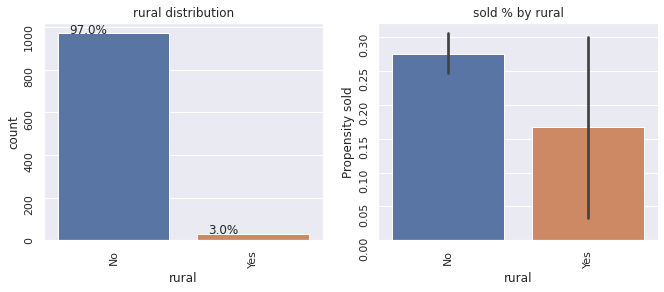

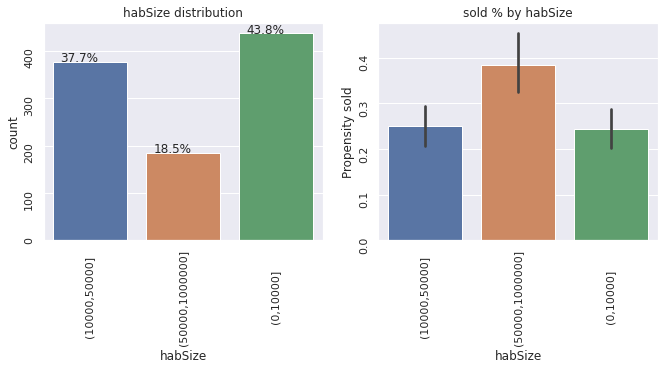

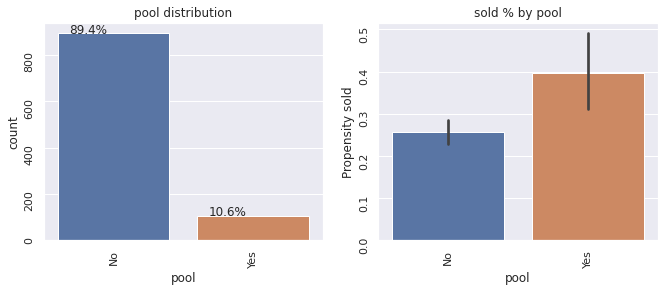

In [46]:
# Hint 1: bivar_bin() function using the parameters method, points, saveTransf
bivar_bin(df,catVar="rural",binVar="sold",method="cut", 
          points=[-np.infty,15,17,np.infty], saveTransf=True)

bivar_bin(df,catVar="habSize",binVar="sold",method="cut", 
          points=[-np.infty,15,17,np.infty], saveTransf=True)

bivar_bin(df,catVar="pool",binVar="sold",method="cut", 
          points=[-np.infty,15,17,np.infty], saveTransf=True)


### Logistic Model - Propensity to be sold

In [52]:
# Hint 1: Adjust the model with mod2 = sm.Logit.from_formula().fit()
# Hint 2: Interpretation should be done with mod2.summary() and mod2.get_margeff(dummy=True).summary() 
# Hint 3: Influential values could be analyzed with mod3=GLM.from_formula().fit(), mod3.get_influence().plot_influence() and mod3.get_influence().cooks_distance[0]  

model2 = sm.Logit.from_formula(formula='sold ~ rural + pool + habSize + np.log(surface) + log_price', data=df)

model2 = model2.fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.529322
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   sold   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      993
Method:                           MLE   Df Model:                            6
Date:                Wed, 02 Mar 2022   Pseudo R-squ.:                 0.09554
Time:                        22:31:26   Log-Likelihood:                -529.32
converged:                       True   LL-Null:                       -585.24
Covariance Type:            nonrobust   LLR p-value:                 8.428e-22
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     12.5501      2.271      5.527      0.000       8.099      17.001
rural[T.Yes]                  -1.6347      0.523     -3.129      0.002      -2.659      -0.611
pool[T.Yes]                    1.1246      0.234      4.804      0.000       0.666       1.583
habSize[T.(10000,50000]  ]     0.4503      0.178      2.531      0.011       0.102       0.799
habSize[T.(50000,1000000]]     1.0164      0.203      5.004      0.000       0.618       1.414
np.log(surface)                1.8613      0.246      7.551      0.000       1.378       2.344
log_price                     -1.9087      0.236     -8.102      0.000      -2.370      -1.447
==============================================================================================
"""

In [51]:
model2.get_margeff(dummy=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                   sold
Method:                          dydx
At:                           overall
==============================================================================================
                                dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
rural[T.Yes]                  -0.2011      0.039     -5.212      0.000      -0.277      -0.125
pool[T.Yes]                    0.2235      0.048      4.614      0.000       0.129       0.318
habSize[T.(10000,50000]  ]     0.0803      0.032      2.533      0.011       0.018       0.142
habSize[T.(50000,1000000]]     0.1975      0.041      4.831      0.000       0.117       0.278
np.log(surface)                0.3278      0.039      8.312      0.000       0.251       0.405
log_price                     -0.3362      0.037     -9.102      0.000      -0.409      -0.264
==============================================================================================
"""

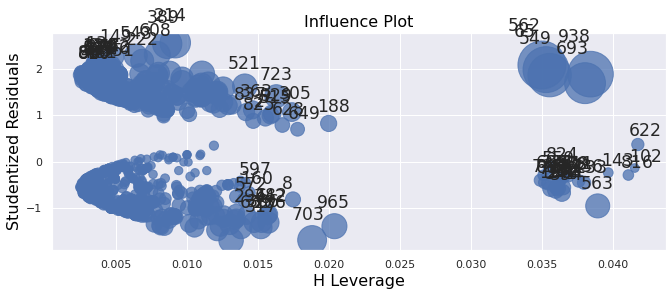

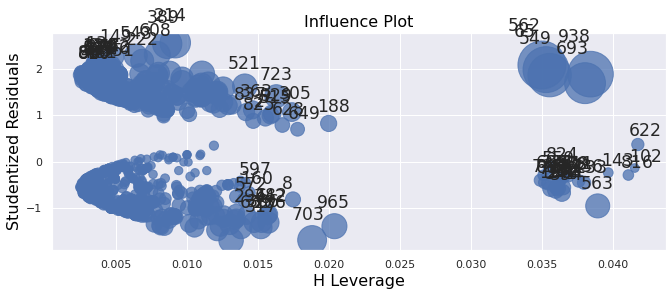

In [62]:
model3 = GLM.from_formula(formula='sold ~  rural + log_price + pool + habSize + np.log(surface)', data=df).fit()

model3_influence = model3.get_influence()
model3_influence.plot_influence()

In [65]:
cooks_distance = model3.get_influence().cooks_distance[0]

Comment:

### Conditional probabilities

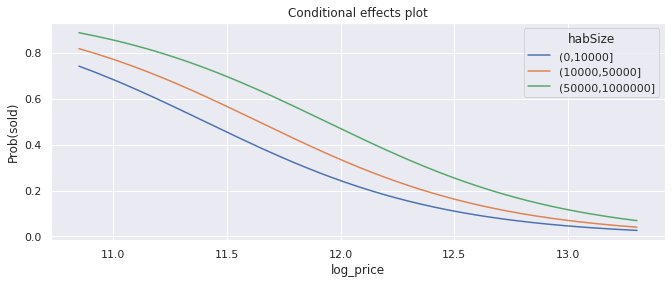

In [84]:
# use visreg(). All explanatory variables, except xvar and by, should have been fixed in the cond dictionary.
visreg(model2, 
       xvar = "log_price", 
       by = "habSize",
       data = df,
       cond = {'rural':'No',
             'surface': df["surface"].median(),
             'pool':'No'}
       )

Comment: In the graph we can see the probability of selling a property given that it's on a non-rural area, and it doesn't have a pool for the median house, conditional on the price for each braket of habSize.

### Optimall selling price strategy unsold properties

> Hint: Fix the selling price from a global policy of Propensity to be sold. 

Comment:

The unsold propeties need to lower their price in order to get closer to the market value. As we saw in a previous section, they are overpriced by about 20% 
